!pip install matplotlib numpy notebook tensorflow==2.5.0 tensorflow-addons tensorflow-model-optimization

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

D:\anaconda\envs\test\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS= 50

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE) 

Found 2152 files belonging to 3 classes.


In [5]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=5)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [7]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [8]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [10]:
data_augmentation=tf.keras.Sequential([
      layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
      layers.experimental.preprocessing.RandomRotation(0.2),
      layers.experimental.preprocessing.RandomZoom(0.2),
      layers.experimental.preprocessing.RandomContrast(0.1),
])

In [11]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

In [12]:
model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
)

In [13]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 20s 155ms/step - loss: 0.9358 - accuracy: 0.4707 - val_loss: 0.9833 - val_accuracy: 0.4167
Epoch 2/50
54/54 [==============================] - 5s 95ms/step - loss: 0.7838 - accuracy: 0.5980 - val_loss: 0.8223 - val_accuracy: 0.5938
Epoch 3/50
54/54 [==============================] - 5s 96ms/step - loss: 0.5275 - accuracy: 0.7964 - val_loss: 0.4674 - val_accuracy: 0.8021
Epoch 4/50
54/54 [==============================] - 5s 96ms/step - loss: 0.4754 - accuracy: 0.8128 - val_loss: 0.6431 - val_accuracy: 0.7708
Epoch 5/50
54/54 [==============================] - 5s 96ms/step - loss: 0.4367 - accuracy: 0.8198 - val_loss: 0.5705 - val_accuracy: 0.7448
Epoch 6/50
54/54 [==============================] - 5s 96ms/step - loss: 0.3711 - accuracy: 0.8509 - val_loss: 0.7707 - val_accuracy: 0.7396
Epoch 7/50
54/54 [==============================] - 5s 96ms/step - loss: 0.3063 - accuracy: 0.8879 - val_loss: 0.4312 - val_accuracy: 0.8333
Epoch 8/50


In [14]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 3s 47ms/step - loss: 0.0140 - accuracy: 0.9961


In [15]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

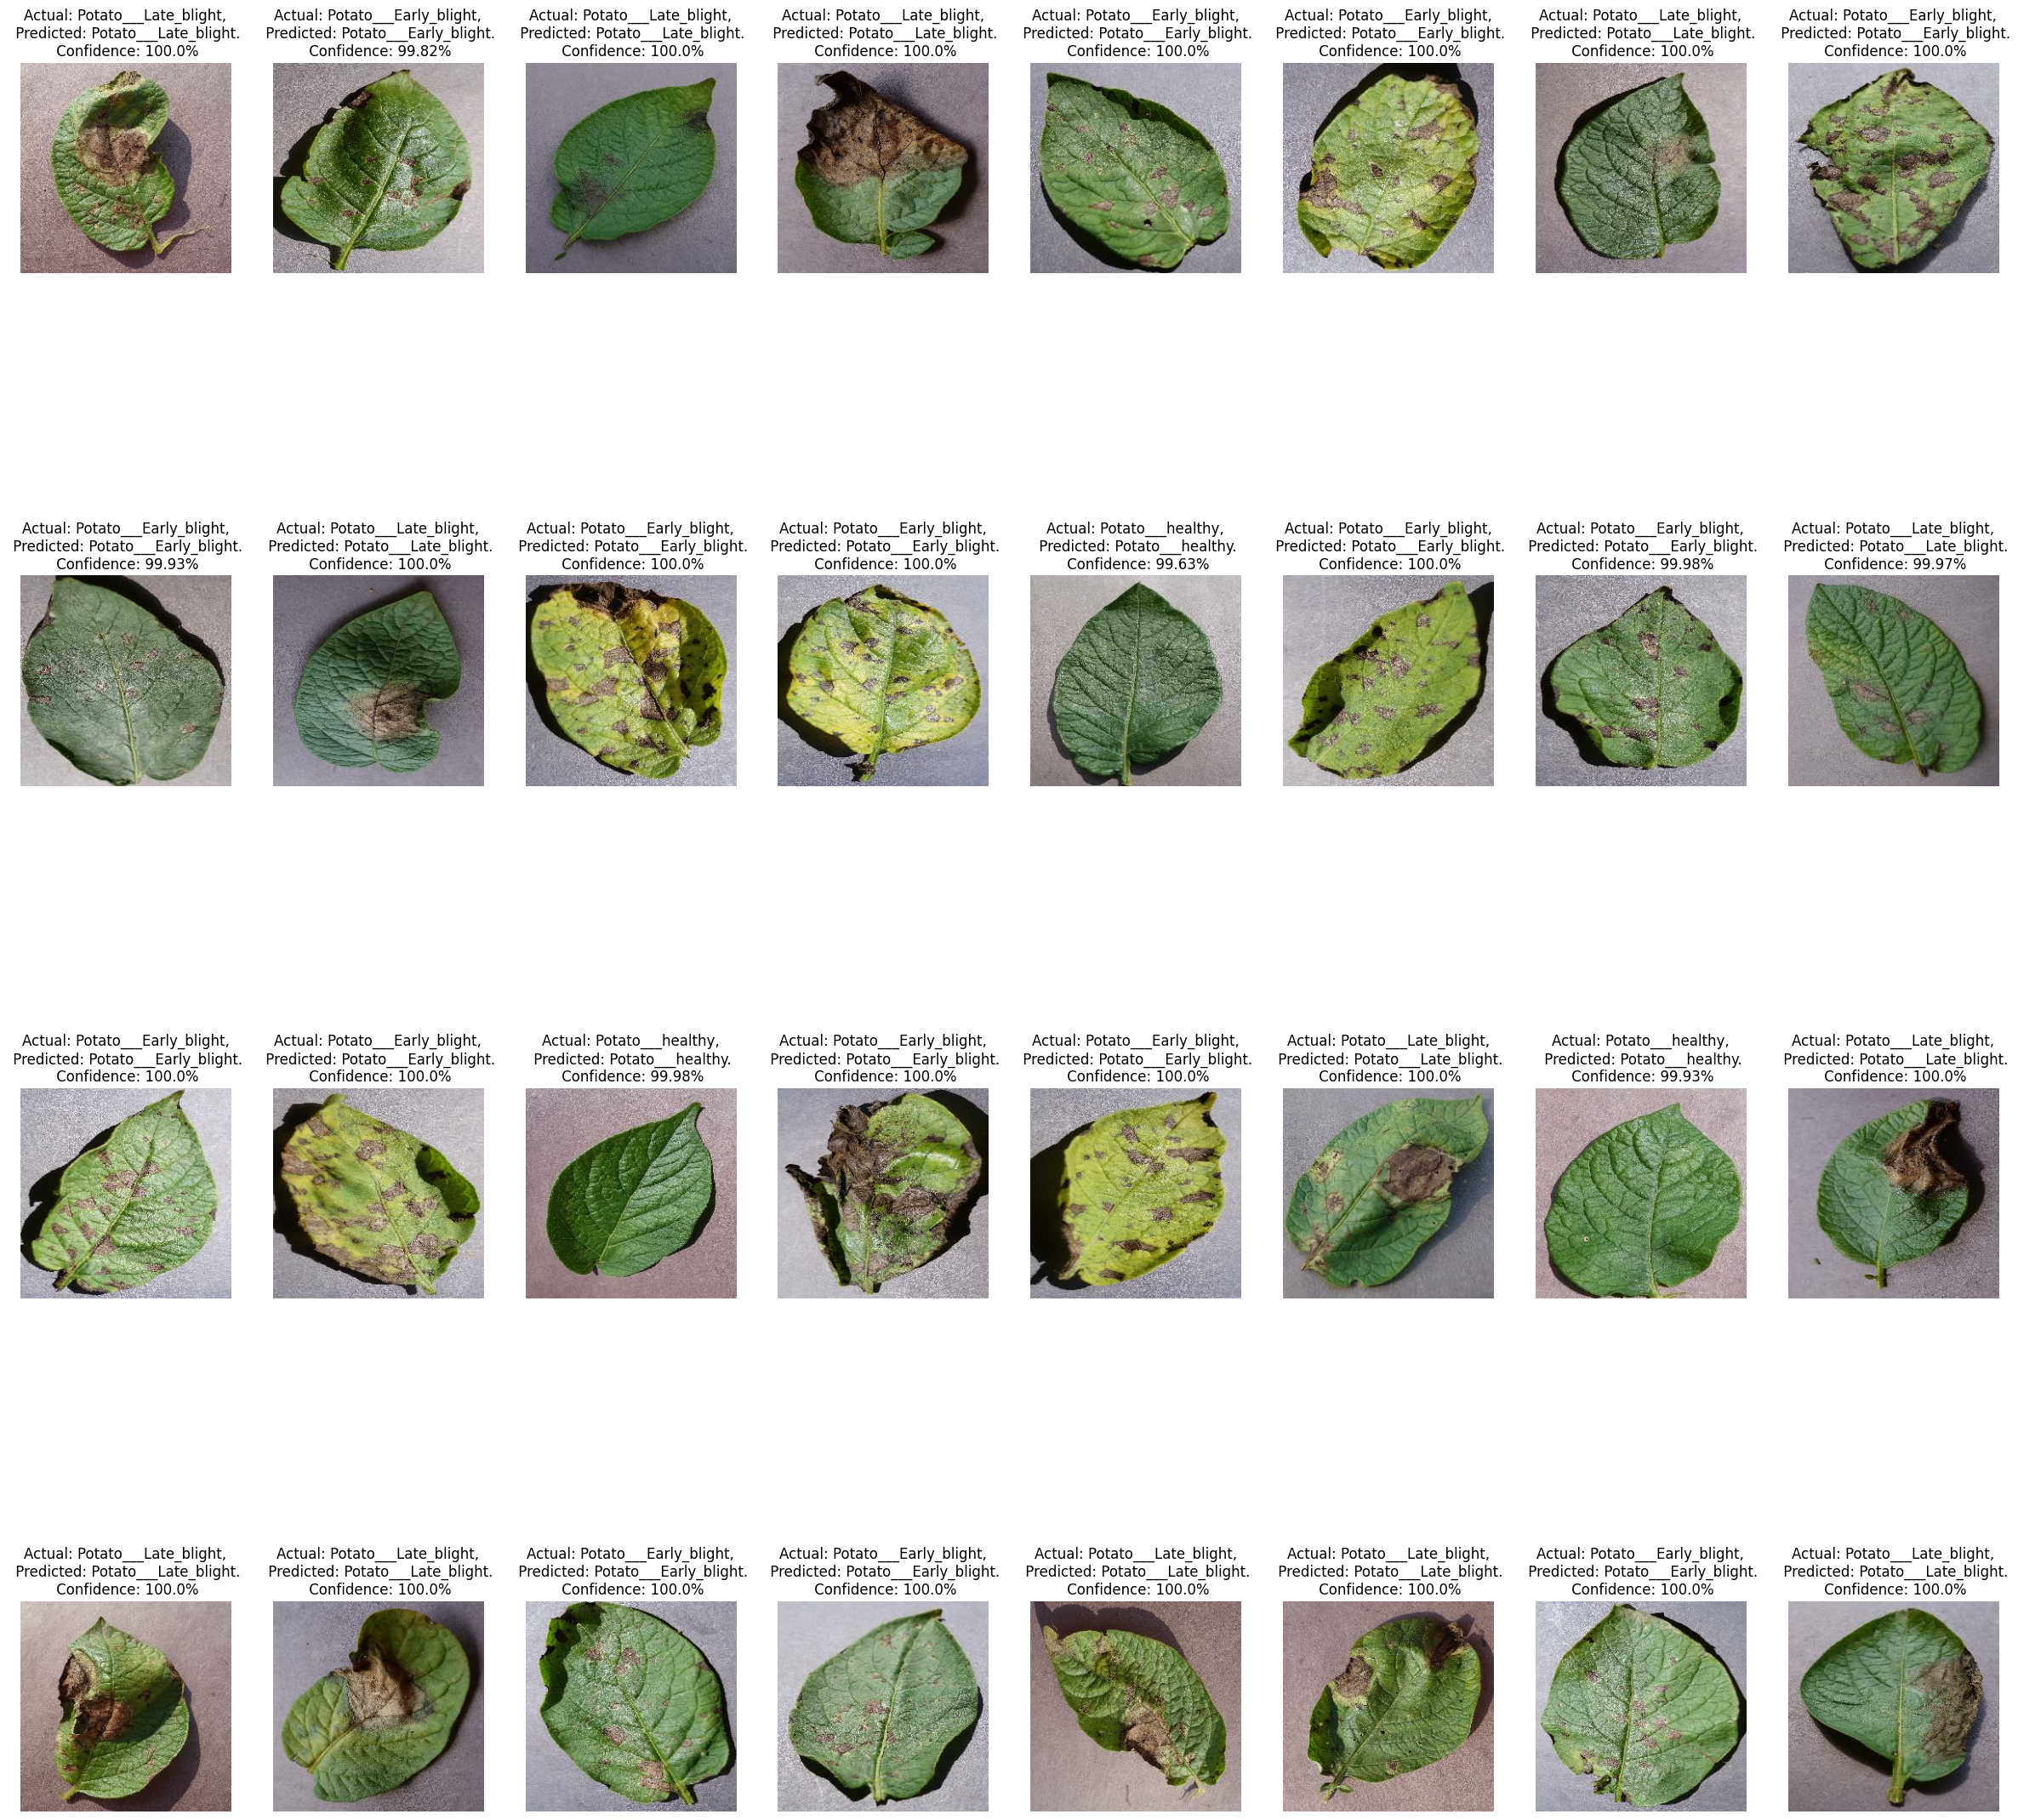

In [16]:
plt.figure(figsize=(30,30))
for images, labels in test_ds.take(1):
    for i in range(32):
        ax=plt.subplot(4,8,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [18]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets
